/usr/lib/python3/dist-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/usr/lib/python3/dist-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu


lag 10, tailOffset 0.020000, tail index 2.022730
            date   price   returns  absreturn
8613  1990-11-23  4926.0  0.406625   0.406625
8636  1990-10-24  3519.0  0.343130   0.343130
8614  1990-11-22  4614.0  0.328917   0.328917
8691  1990-08-13  3884.0 -0.326980   0.326980
9512  1987-09-25  4364.7  0.312333   0.312333
lag 10, tailOffset 0.005000, tail index 2.686649
            date   price   returns  absreturn
7858  1987-10-19  224.84 -0.314679   0.314679
7853  1987-10-26  227.67 -0.264133   0.264133
2567  2008-10-10  899.22 -0.258846   0.258846
7852  1987-10-27  233.19 -0.258585   0.258585
7857  1987-10-20  236.83 -0.258098   0.258098


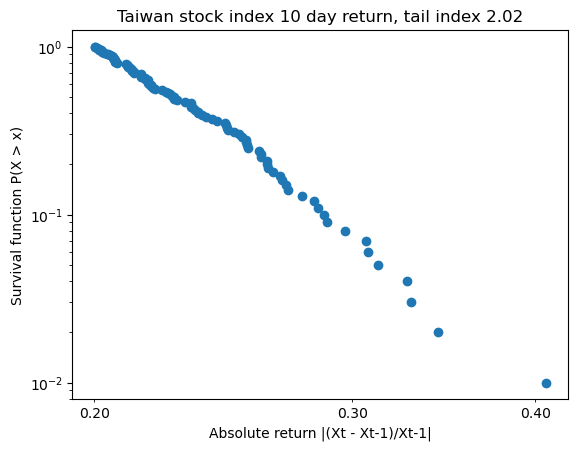

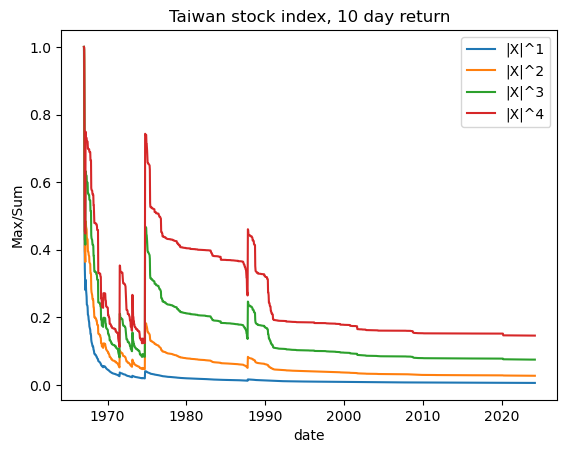

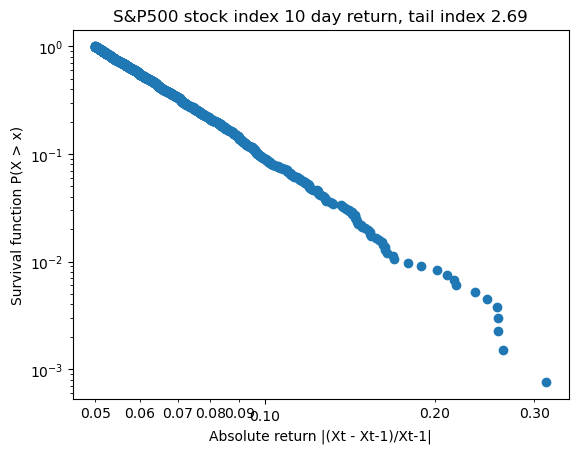

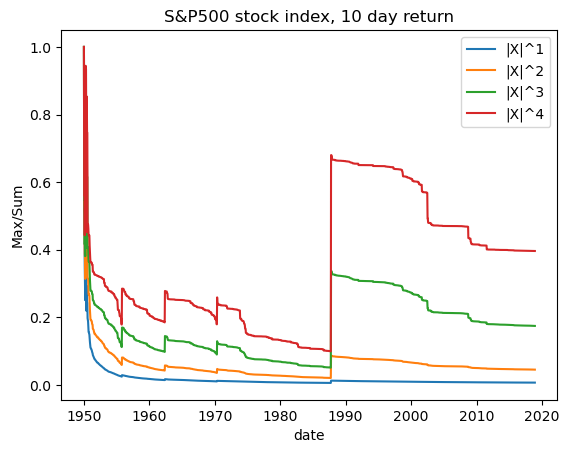

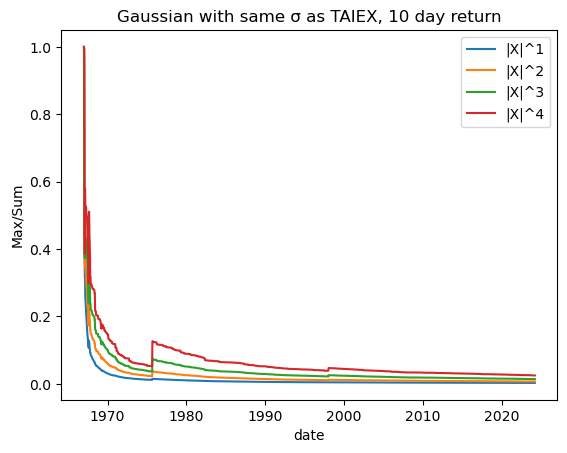

In [80]:
import numpy as np
import pandas
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt


class Analysis:
    def __init__(self):
        self.name = ""
        self.fpath = ""

        self.lag = 1
        self.tailCutoff = 0.001


def analyzePareto(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    df["returns"] = df.price / df.price.shift(-analysis.lag)-1
    df.drop(df.tail(analysis.lag).index,inplace=True)
    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]
    
    pareto = scipy.stats.pareto.fit(df.absreturn, scale=analysis.lag*0.02)
    tailIndex = pareto[0]
    print("lag %d, tailOffset %f, tail index %f" % (analysis.lag, analysis.tailCutoff, tailIndex))
    df = df.sort_values(by='absreturn', ascending=False)
    print(df.head(5))
    
    df["survival"] = 1-(df.absreturn.rank()-1) / len(df)
    fig, ax = plt.subplots(1, 1)
    ax.scatter(df.absreturn, df.survival)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
    ax.set_title("%s %d day return, tail index %.2f" % (analysis.name, analysis.lag, tailIndex))
    ax.set_xlabel("Absolute return |(Xt - Xt-1)/Xt-1|")
    ax.set_ylabel("Survival function P(X > x)")


def analyzeMSp(df, p):
    df["Xp%d" % p] = np.power(df.absreturn, p)

    df["msMax%d" % p] = df["Xp%d" % p].cummax()
    if False:
        k = 10
        for i in range(len(df)):
            subset = df.iloc[:i+1]
            vs = subset["Xp%d" % p].to_numpy().copy()
    
            vs = np.sort(vs)
            largest = vs[max(0, len(vs)-k):]
            mx = np.sum(largest)
    
            df.iloc[i, df.columns.get_loc("msMax%d" % p)] = mx
            
    
    df["msSum%d" % p] = df["Xp%d" % p].cumsum()
    df["ms%d" % p] = df["msMax%d" % p] / df["msSum%d" % p]


def plotMS(analysis, df):
    fig, ax = plt.subplots(1, 1)
    for p in [1, 2, 3, 4]:
        analyzeMSp(df, p)
        x = matplotlib.dates.date2num(df.date)
        y = df["ms%d" % p].to_numpy()
        x = x[0:]
        y = y[0:]
        ax.plot_date(x, y, fmt="-", label=("|X|^%d" % p))
    ax.legend()
    ax.set_title("%s, %d day return" % (analysis.name, analysis.lag))
    ax.set_xlabel("date")
    ax.set_ylabel("Max/Sum")


def analyzeMS(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    df = df.sort_values(by='date', ascending=True)
    df = df.iloc[::analysis.lag, :]
    df["returns"] = df.price / df.price.shift(-1)-1
    #df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)
    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))

    plotMS(analysis, df)
    #df.to_csv("qqq.csv")


def analyze(analysis):
    analyzePareto(analysis)
    analyzeMS(analysis)


for lag in [10]:
    for tailCutoff in [0.02]:
        analysis = Analysis()
        analysis.name = "Taiwan stock index"
        analysis.fpath = "taiex.csv"
        analysis.lag = lag
        analysis.tailCutoff = tailCutoff
        analyze(analysis)
        
        analysis.name = "S&P500 stock index"
        analysis.fpath = "sp500.csv"
        analysis.tailCutoff = 0.005
        analyze(analysis)


# Plot a MS-plot for a normal distribution corresponding to TAIEX.
analysis = Analysis()
analysis.name = "Gaussian with same σ as TAIEX"
analysis.lag = 10
# Compute daily standard deviation
df = pandas.read_csv("taiex.csv", dtype={'price': np.float64})
df = df.sort_values(by='date', ascending=True)
df["returns"] = df.price / df.price.shift(-1)-1
df.drop(df.tail(1).index,inplace=True)
std = np.std(df.returns)
# Simulate a normal distribution using the computed standard deviation.
df = df.iloc[::analysis.lag, :]
df["absreturn"] = np.abs(np.random.normal(scale=analysis.lag*std, size=len(df)))
plotMS(analysis, df)